Downloads dataset from repository, unzips and mounts to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dataset_name = 'behaviour_biometrics_dataset'

dataset_url = 'https://drive.google.com/file/d/1t1yGjyO6hwAaYvlO_Chu0jgRAf8oVqAF/view?usp=sharing'

dataset_url4wget = 'https://docs.google.com/uc?export=download&id=1t1yGjyO6hwAaYvlO_Chu0jgRAf8oVqAF'

!wget -r --no-check-certificate "$dataset_url4wget" -O $dataset_name".zip"
!ls

!unzip  $dataset_name".zip"
!ls

Mounted at /content/drive
will be placed in the single file you specified.

--2023-10-22 13:19:31--  https://docs.google.com/uc?export=download&id=1t1yGjyO6hwAaYvlO_Chu0jgRAf8oVqAF
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.138, 74.125.142.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5ngrahp49nae2f1evqk2265g0gc7s7pr/1697980725000/01161134783015454804/*/1t1yGjyO6hwAaYvlO_Chu0jgRAf8oVqAF?e=download&uuid=6ab43031-6189-4585-abf2-176ab25152a1 [following]
--2023-10-22 13:19:55--  https://doc-14-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5ngrahp49nae2f1evqk2265g0gc7s7pr/1697980725000/01161134783015454804/*/1t1yGjyO6hwAaYvlO_Chu0jgRAf8oVqAF?e=download&uuid=6ab43031-6189-4585-abf2-176ab25152a1
Resolving doc-14-50-docs.googleusercont

#Libraries


Imports the key libraries used within this .IPYNB file.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import pandas as pd
import math

#Core Methods

Executes the methods necessary to run experiments

In [ ]:
# CONVERTS DICTIONARIES TAKEN FROM .JSON FILES INTO DATAFRAMES FOR THE KEY EVENTS
def dict_key_conversion(data):
    temp_df = pd.DataFrame(columns=['test_number', 'dwell_time', 'flight_time', 'key_pressed'])
    temp_flight_df = pd.DataFrame(columns=['test_number', 'flight_time', 'key_released'])

    temp_df_count = 0 # indicates which row of the df the next row of data should be appeneded into
    temp_flight_df_count = 0

    for i in range(1, 11): # loops through each of the tests in true_data
        k_data = data['test_'+str(i)]['key_events']
        # removes tabs from the data, as kivy, which is the library used for data collection, doesn't register tab releases, only presses
        tabless_k_data = []
        for k in k_data:
            if k['Key'] != 'tab':
                tabless_k_data.append(k)

        count = 0 #counter for how many iterations into the for loop it is
        f_count = 0 #counter for how many iterations into the loop the flight section has done
        prev_key_press = 0
        prev_key_release = 0
        for j in tabless_k_data:
            if j['Event'] == 'pressed': # THIS EXECUTES TO FIND THE DWELL TIME
                flight_impute = 0 # imputes flight time as 0 for now, as there are instances of key presses not having releases at the end of the test
                key_id = j['Key'] # this is what the actual key that is being pressed/released is
                key_press_time = j['Epoch'] # the epoch time of the key press
                key_release = False # is true when the release of the key has been found
                cont_count = 1 # keeps track of counting from the current key press, as it loops from

                while key_release == False: # continues
                    c = cont_count + count
                    start_row = tabless_k_data[count]
                    next_row = tabless_k_data[c]
                    # executes if the row is the release of the key that was pressed, and exits the while loop
                    if next_row['Key'] == key_id and next_row['Event'] == 'released':
                        key_release_time = next_row['Epoch']
                        dwell_time = float(key_release_time) - float(key_press_time)
                        key_release = True
                    # executes if the next row is a press event for a different key
                    elif next_row['Key'] != key_id and next_row['Event'] == 'pressed':
                        cont_count += 1
                    elif next_row['Key'] != key_id and next_row['Event'] == 'released':
                        cont_count += 1
                    else:
                        key_release = True
                        dwell_time = 0
                        key_release_time = start_row['Epoch']

                temp_df.loc[temp_df_count] = [i, dwell_time, flight_impute, key_id]

                prev_key_press = key_press_time
                prev_key_release = key_release_time
                temp_df_count += 1

            count += 1

            if j['Event'] == 'released': # THIS EXECUTES TO FIND THE FLIGHT TIME
                key_id = j['Key']
                f_cont_count = 1
                flight_time = []
                flight_found = False
                while flight_found == False:
                    f_c = f_count + f_cont_count
                    if f_c < len(tabless_k_data):
                        next_row = tabless_k_data[f_c]
                        if next_row['Event'] == 'pressed' and next_row['Key'] != key_id:
                            flight_time = float(next_row['Epoch']) - float(j['Epoch'])
                            temp_flight_df.loc[temp_flight_df_count] = [i, flight_time, key_id]
                            temp_flight_df_count += 1
                            flight_found = True
                        f_cont_count += 1
                    else:
                        flight_found = True
            f_count += 1

    # Now merges the flight time df with the rest of the features
    for i in range(1, 11):
        fh_count = 0
        flight_hold = []
        for j in temp_flight_df.index:
            if temp_flight_df.at[j, 'test_number'] == i:
                flight_hold.append(temp_flight_df.at[j, 'flight_time'])
        fh_count = 0

        for j in temp_df.index:
            if temp_df.at[j, 'test_number'] == i and fh_count < len(flight_hold):
                temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
                fh_count += 1

    true_k_df = temp_df
    return true_k_df

In [ ]:
# CONVERTS DICTIONARIES TAKEN FROM .JSON FILES INTO DATAFRAMES FOR THE MOUSE EVENTS
def get_distance(a, b): # method used to calculate distance between two coordinates
    distance = math.sqrt(((a[0] - b[0]) ** 2) + ((a[1] - b[1]) ** 2))
    return distance

def dict_mouse_conversion(data):
    m_df = pd.DataFrame(columns = ['test_number', 'movement_id', 'trajectory', 'single_coor'])
    row_count = 0
    for i in range(1, 11):
        m_data = data['test_'+str(i)]['mouse_events']
        m_movements = []
        for j in m_data[:len(m_data)-1]:
            if j['Event'] == 'movement':
                m_movements.append(j)

        # creates dictionary that passes all the movement coordinates to the each movement ID in the test
        movement_coor_dict = {}
        for j in m_movements:
            movement_coor_dict[j['Movement ID']] = []
        for j in m_movements:
            movement_coor_dict[j['Movement ID']].append(j['Coordinates'])

        # calculates the overall trajectory length for each of the movement IDs
        for j in movement_coor_dict:
            coor_list = movement_coor_dict[j]
            motion_start = False
            trajectory = 0
            if len(coor_list) > 1:
                trajectory_list = []
                if motion_start == True:
                    motion_start = False
                else:
                    count = 0
                    for k in coor_list:
                        trajectory_list.append(get_distance(coor_list[count-1], coor_list[count]))
                        count += 1
                    movement_id = j
                    trajectory = sum(trajectory_list)
                    single_coor = False
            else:
                movement_id = 1
                trajectory_list = [0]
                trajectory = 0
                single_coor = False
            m_df.loc[row_count] = [i, movement_id, trajectory, single_coor]
            row_count += 1
    m_df = m_df.sort_values(by=['test_number', 'movement_id'])

    for j in m_df['single_coor'].tolist():
        if j == True:
            m_df = m_df.drop[count]
        count += 1
    m_df = m_df.reset_index(drop=True)
    return m_df

In [ ]:
# GENERATES FEATURES FOR EACH TEST FROM THE DFS GENERATED IN THE PREVIOUS TWO CELLS
def feature_gen(k_data, m_data):
    columns = ['dwell_avg', 'flight_avg', 'traj_avg']

    df = pd.DataFrame(columns=columns)

    # for loop calculates average value for the dwell time, flight time and trajectory for each test
    for i in range(1, 11):
        dwell_list = []
        flight_list = []
        traj_list = []
        for j in k_data.index:
            if k_data.at[j, 'test_number'] == i:
                dwell_list.append(k_data.at[j, 'dwell_time'])
                flight_list.append(k_data.at[j, 'flight_time'])
        for j in m_data.index:
            if m_data.at[j, 'test_number'] == i:
                traj_list.append(m_data.at[j, 'trajectory'])

        dwell_list = [j for j in dwell_list if j != 0]
        flight_list = [j for j in flight_list if j != 0]
        traj_list = [j for j in traj_list if j != 0]

        dwell_avg = sum(dwell_list)/len(dwell_list)
        flight_avg = sum(flight_list)/len(dwell_list)
        traj_avg = sum(traj_list)/len(traj_list)


        agg_data = [dwell_avg, flight_avg, traj_avg]

        df.loc[i] = agg_data
    return df

#Experiments & Results, Visualization



Loads the raw .json files from google drive, generates features for ML classification task, and evaluates the models.

User 1
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 2
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 3
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 4
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 5
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 6
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 7
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 8
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 9
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 10
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 11
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 12

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 14
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 15
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 16
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 17
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 18
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 19
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 20
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 21
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 22
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 23
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 24
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 34
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 35
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 36
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 37
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 38
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 39
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 40
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 41
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 42
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 43
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 44
Target La

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 50
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 51
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 52
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 53
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 54
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 55
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 56
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 57
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
U

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 83
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 84
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 1 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 85
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 86
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 87
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 88
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
 
###########################
##########RESULTS##########
###########################
Accuracy: 0.8039772727272727
F1-Score: 0.7825757575757577


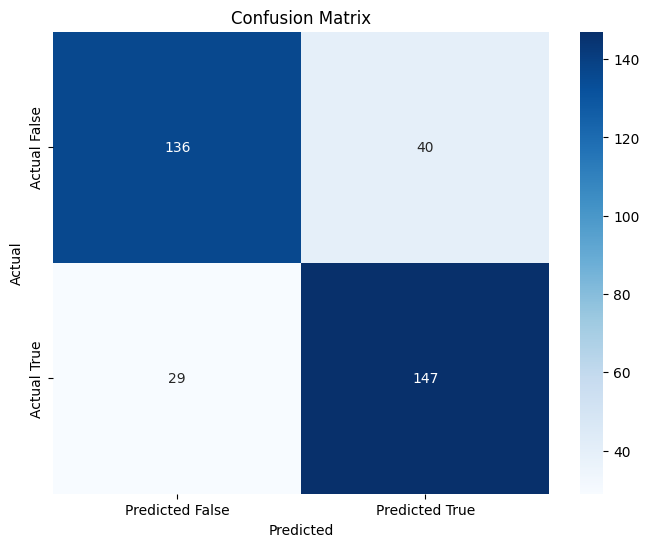

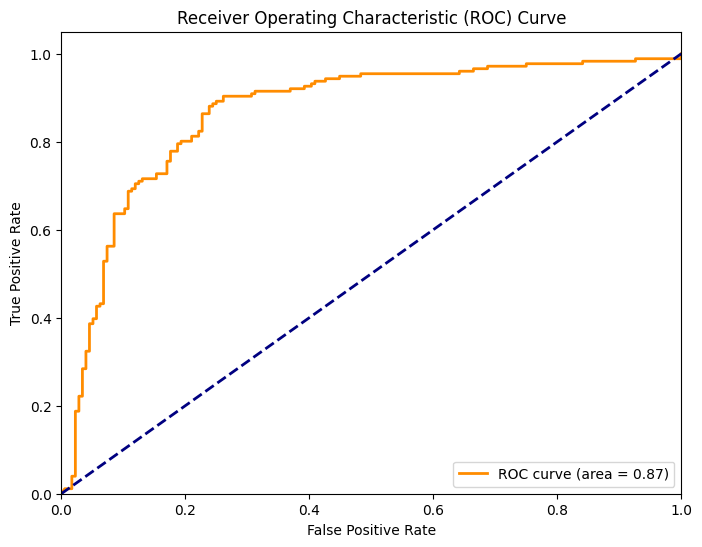

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc


# Temporary list storage for visualization
acc_list = []
fm_list = []
all_true_labels = []  # To store true labels for ROC curve
all_predicted_labels = []  # To store predicted labels for ROC curve

# Initialize the list for confusion matrices
confusion_matrices = []

# Initialize variables for ROC curve
all_true_probabilities = []
all_predicted_probabilities = []
# for naive bayes:

# RUNS THE MODEL ON EACH OF THE USER'S DATA
for i in range(1, 89):
    user_number = i
    user_number = str(user_number).zfill(4)
    f = open('behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')
    data = json.load(f)
    user_details = data['details']
    true_data = data['true_data']
    false_data = data['false_data']

    true_k_df = dict_key_conversion(true_data)
    false_k_df = dict_key_conversion(false_data)

    true_m_df = dict_mouse_conversion(true_data)
    false_m_df = dict_mouse_conversion(false_data)

    true_df = feature_gen(true_k_df, true_m_df)
    false_df = feature_gen(false_k_df, false_m_df)
    true_df['label'] = 1
    false_df['label'] = 0
    final_df = pd.concat([true_df, false_df])
    final_df = final_df.reset_index(drop=True)

    y = final_df['label'].tolist()
    X = final_df.drop(['label'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create and train the Naive Bayes classifier (Gaussian Naive Bayes)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    predicted_labels = clf.predict(X_test)
    clf_rep = classification_report(y_test, predicted_labels, output_dict=True)
    acc = clf_rep['accuracy']
    fm = clf_rep['weighted avg']['f1-score']
    print('User', i)
    print('Target Labels', y_test)
    print('Predicted Labels', predicted_labels)
    print('Accuracy:', acc)
    print('F1-Score:', fm)
    print('----------------------------')

    acc_list.append(acc)
    fm_list.append(fm)
    all_true_labels.extend(y_test)
    all_predicted_labels.extend(predicted_labels)

    # Calculate probabilities for ROC curve
    probabilities = clf.predict_proba(X_test)
    all_true_probabilities.extend(probabilities[:, 1])

final_acc = sum(acc_list) / len(acc_list)
final_fm = sum(fm_list) / len(fm_list)

print(' ')
print('###########################')
print('##########RESULTS##########')
print('###########################')
print('Accuracy:', final_acc)
print('F1-Score:', final_fm)

# Plot the confusion matrix
confusion_matrix_total = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_total, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(all_true_labels, all_true_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


(-0.1, 1.1)

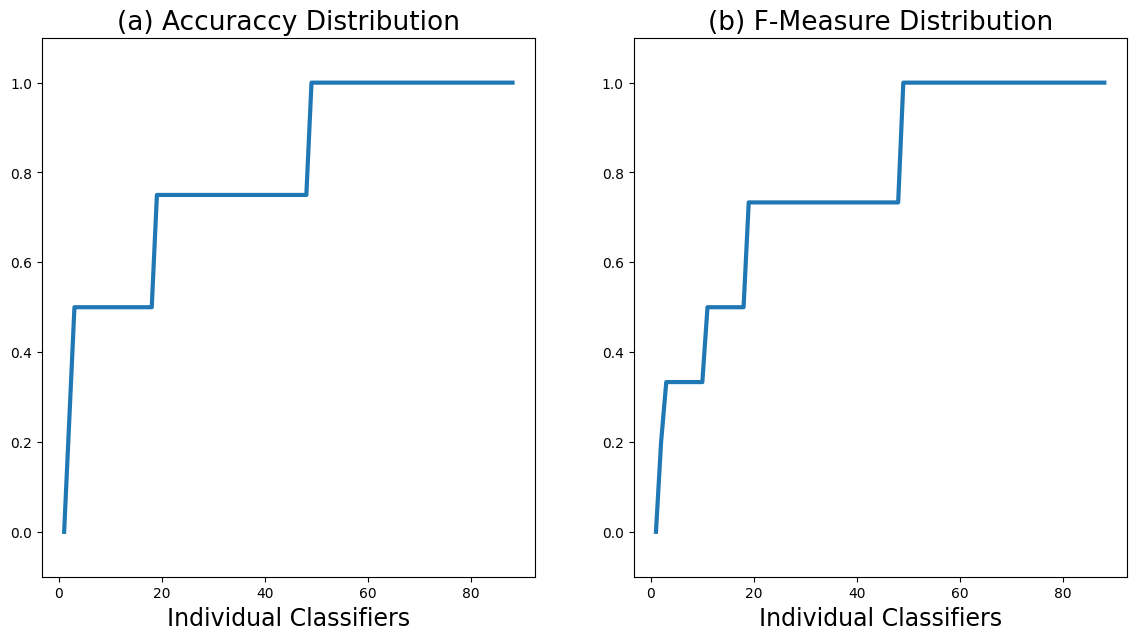

In [ ]:
acc_list.sort()
fm_list.sort()
ind_class = []
for i in range(1, 89):
  ind_class.append(i)

f = plt.figure(figsize=(14, 7))

ax = f.add_subplot(121)
ax.plot(ind_class, acc_list, linewidth=3)
ax.set_title('(a) Accuraccy Distribution', fontsize=19)
ax.set_xlabel('Individual Classifiers', fontsize=17)
ax.set_ylim(-.1, 1.1)

ax2 = f.add_subplot(122)
ax2.plot(ind_class, fm_list, linewidth=3)
ax2.set_title('(b) F-Measure Distribution', fontsize=19)
ax2.set_xlabel('Individual Classifiers', fontsize=17)
ax2.set_ylim(-.1, 1.1)

User 1
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 2
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 3
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 4
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 5
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 6
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 7
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 8
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 9
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 10
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 11
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 12
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 13
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 1]
Accuracy: 0.25
F1-Score: 0.2
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 14
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 15
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 16
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 17
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 18
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 19
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 20
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 21
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 22
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 23
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 24
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 36
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 37
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 38
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 39
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 40
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 41
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 42
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 43
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.733333333333333

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 75
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 76
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 77
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 78
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 79
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 80
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 81
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 1 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 82
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
--------------

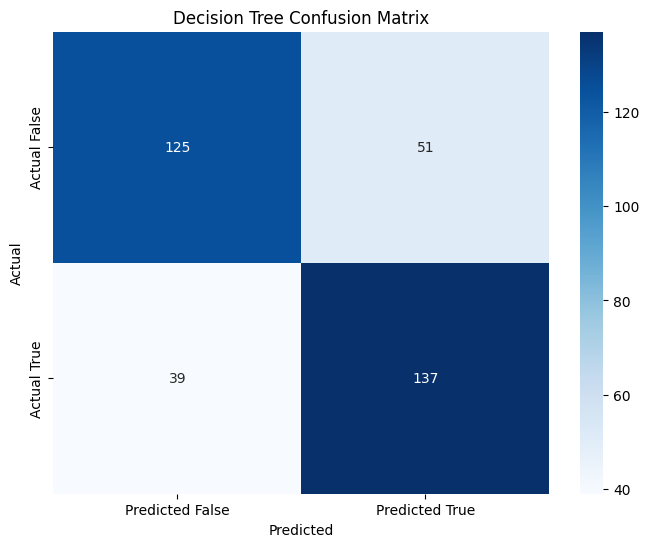

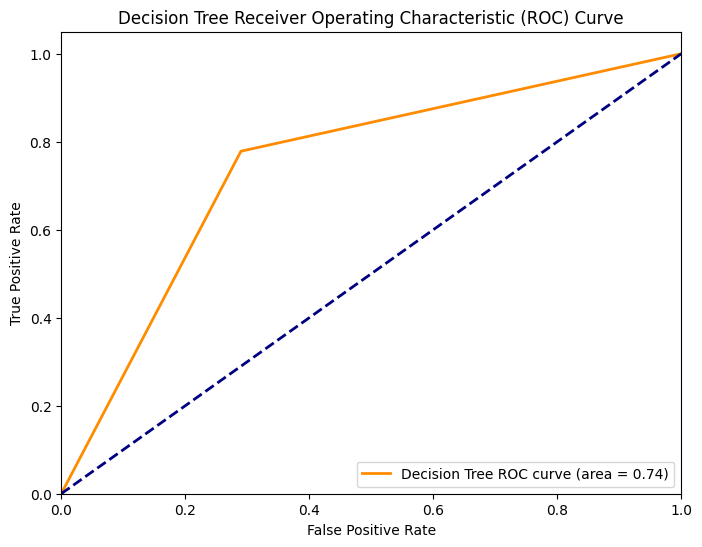

In [ ]:
#for decision tree
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree classifier

# Initialize lists for storing accuracy and F1-Score
acc_list_dt = []
fm_list_dt = []
all_true_labels_dt = []
all_predicted_labels_dt = []
all_true_probabilities_dt = []

for i in range(1, 89):
    user_number = i
    user_number = str(user_number).zfill(4)
    f = open('behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')
    data = json.load(f)
    user_details = data['details']
    true_data = data['true_data']
    false_data = data['false_data']

    true_k_df = dict_key_conversion(true_data)
    false_k_df = dict_key_conversion(false_data)

    true_m_df = dict_mouse_conversion(true_data)
    false_m_df = dict_mouse_conversion(false_data)

    true_df = feature_gen(true_k_df, true_m_df)
    false_df = feature_gen(false_k_df, false_m_df)
    true_df['label'] = 1
    false_df['label'] = 0
    final_df = pd.concat([true_df, false_df])
    final_df = final_df.reset_index(drop=True)

    y = final_df['label'].tolist()
    X = final_df.drop(['label'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create and train the Decision Tree classifier
    clf_dt = DecisionTreeClassifier()  # Use Decision Tree classifier
    clf_dt.fit(X_train, y_train)
    predicted_labels = clf_dt.predict(X_test)
    clf_rep = classification_report(y_test, predicted_labels, output_dict=True)
    acc = clf_rep['accuracy']
    fm = clf_rep['weighted avg']['f1-score']
    print('User', i)
    print('Target Labels', y_test)
    print('Predicted Labels', predicted_labels)
    print('Accuracy:', acc)
    print('F1-Score:', fm)
    print('----------------------------')

    acc_list_dt.append(acc)
    fm_list_dt.append(fm)
    all_true_labels_dt.extend(y_test)
    all_predicted_labels_dt.extend(predicted_labels)

    # Calculate probabilities for ROC curve
    probabilities = clf_dt.predict_proba(X_test)  # Note: Decision Trees don't have predict_proba, but this line is kept for consistency
    all_true_probabilities_dt.extend(probabilities[:, 1])

final_acc_dt = sum(acc_list_dt) / len(acc_list_dt)
final_fm_dt = sum(fm_list_dt) / len(fm_list_dt)

print(' ')
print('###########################')
print('##########RESULTS##########')
print('###########################')
print('Decision Tree Accuracy:', final_acc_dt)
print('Decision Tree F1-Score:', final_fm_dt)

# Plot the confusion matrix
confusion_matrix_total_dt = confusion_matrix(all_true_labels_dt, all_predicted_labels_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_total_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC
fpr_dt, tpr_dt, _ = roc_curve(all_true_labels_dt, all_true_probabilities_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'Decision Tree ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


User 1
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 2
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 3
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 4
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 5
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 6
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 7
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 8
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 9
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 10
Target Labels [0,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 11
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 12
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 13
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 14
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 15
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 16
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 17
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 18
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 19
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 20
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 21
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 22
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 23
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 24
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 25
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 26
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 1]
Accuracy: 0.25
F1-Score: 0.2
----------------------------
User 27
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 34
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 35
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 36
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 37
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 38
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 39
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 40
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 41
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 53
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 54
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 55
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 56
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 57
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 58
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 59
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 1]
Accuracy: 0.25
F1-Score: 0.2
----------------------------
User 60
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


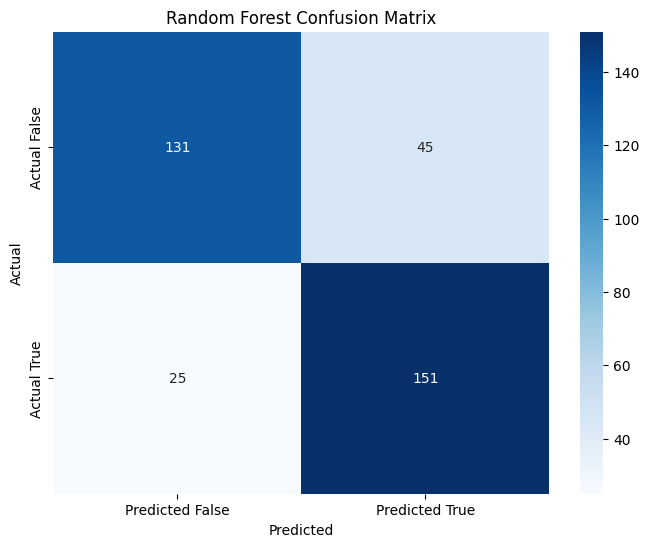

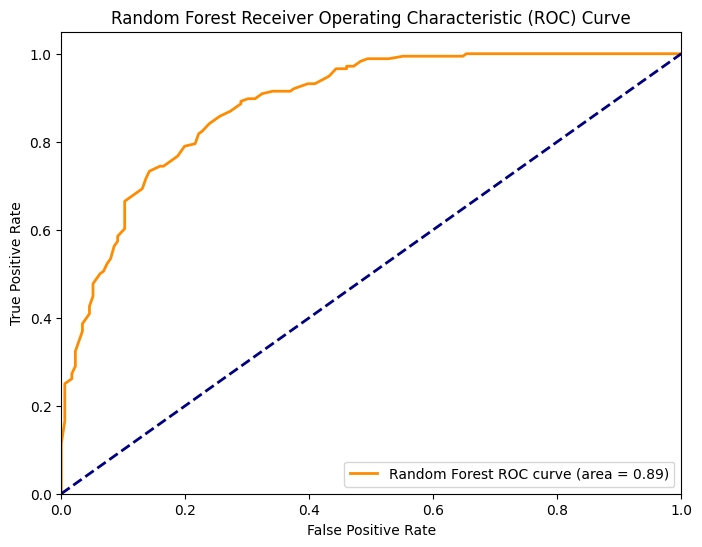

In [ ]:
# for decision tree
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest classifier

# Initialize lists for storing accuracy and F1-Score
acc_list_rf = []
fm_list_rf = []
all_true_labels_rf = []
all_predicted_labels_rf = []
all_true_probabilities_rf = []

for i in range(1, 89):
    user_number = i
    user_number = str(user_number).zfill(4)
    f = open('behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')
    data = json.load(f)
    user_details = data['details']
    true_data = data['true_data']
    false_data = data['false_data']

    true_k_df_rf = dict_key_conversion(true_data)
    false_k_df_rf = dict_key_conversion(false_data)

    true_m_df_rf = dict_mouse_conversion(true_data)
    false_m_df_rf = dict_mouse_conversion(false_data)

    true_df_rf = feature_gen(true_k_df_rf, true_m_df_rf)
    false_df_rf = feature_gen(false_k_df_rf, false_m_df_rf)
    true_df_rf['label'] = 1
    false_df_rf['label'] = 0
    final_df_rf = pd.concat([true_df_rf, false_df_rf])
    final_df_rf = final_df_rf.reset_index(drop=True)

    y_rf = final_df_rf['label'].tolist()
    X_rf = final_df_rf.drop(['label'], axis=1)
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=0)

    # Create and train the Random Forest classifier
    clf_rf = RandomForestClassifier()  # Use Random Forest classifier
    clf_rf.fit(X_train_rf, y_train_rf)
    predicted_labels_rf = clf_rf.predict(X_test_rf)
    clf_rep_rf = classification_report(y_test_rf, predicted_labels_rf, output_dict=True)
    acc_rf = clf_rep_rf['accuracy']
    fm_rf = clf_rep_rf['weighted avg']['f1-score']
    print('User', i)
    print('Target Labels', y_test_rf)
    print('Predicted Labels', predicted_labels_rf)
    print('Accuracy:', acc_rf)
    print('F1-Score:', fm_rf)
    print('----------------------------')

    acc_list_rf.append(acc_rf)
    fm_list_rf.append(fm_rf)
    all_true_labels_rf.extend(y_test_rf)
    all_predicted_labels_rf.extend(predicted_labels_rf)

    # Calculate probabilities for ROC curve
    probabilities_rf = clf_rf.predict_proba(X_test_rf)
    all_true_probabilities_rf.extend(probabilities_rf[:, 1])

final_acc_rf = sum(acc_list_rf) / len(acc_list_rf)
final_fm_rf = sum(fm_list_rf) / len(fm_list_rf)

print(' ')
print('###########################')
print('##########RESULTS##########')
print('###########################')
print('Random Forest Accuracy:', final_acc_rf)
print('Random Forest F1-Score:', final_fm_rf)

# Plot the confusion matrix
confusion_matrix_total_rf = confusion_matrix(all_true_labels_rf, all_predicted_labels_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_total_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(all_true_labels_rf, all_true_probabilities_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


User 1
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 2
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 3
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 4
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 5
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 6
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 1]
Accuracy: 0.25
F1-Score: 0.2
----------------------------
User 7
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 8
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 9
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 10
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 11
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 12
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 13
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 14
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 1]
Accuracy: 0.25
F1-Score: 0.2
----------------------------
User 15
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 23
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 24
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 25
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 26
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 1 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 27
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 28
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 29
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 30
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 31
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 32
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 33
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 34
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 35
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 36
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 0]
Accuracy: 0.0
F1-Score: 0.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 37
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 38
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 39
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 40
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 41
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 42
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 43
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 44
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 0]
Accuracy: 0.25
F1-Score: 0.2
----------------------------
User 45
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 46
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 47
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 48
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 0]
Accuracy: 0.25
F1-Score: 0.2
----------------------------
User 49
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 50
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 0]
Accuracy: 0.0
F1-Score: 0.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 51
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 52
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 53
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 0]
Accuracy: 0.0
F1-Score: 0.0
----------------------------
User 54
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 55
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 56
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 57
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 58
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 59
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 60
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 61
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 62
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 63
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 64
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 65
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 66
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 67
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 68
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 69
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 70
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 71
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 72
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 73
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 74
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 75
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 76
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 77
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 78
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 0]
Accuracy: 0.25
F1-Score: 0.2
----------------------------
User 79
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 80
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 81
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 82
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 83
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


User 84
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
F1-Score: 0.3333333333333333
----------------------------
User 85
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
F1-Score: 0.5
----------------------------
User 86
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
F1-Score: 1.0
----------------------------
User 87
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
User 88
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
F1-Score: 0.7333333333333334
----------------------------
 
###########################
##########RESULTS##########
###########################
SVM Accuracy: 0.6363636363636364
SVM F1-Score: 0.585984848484849


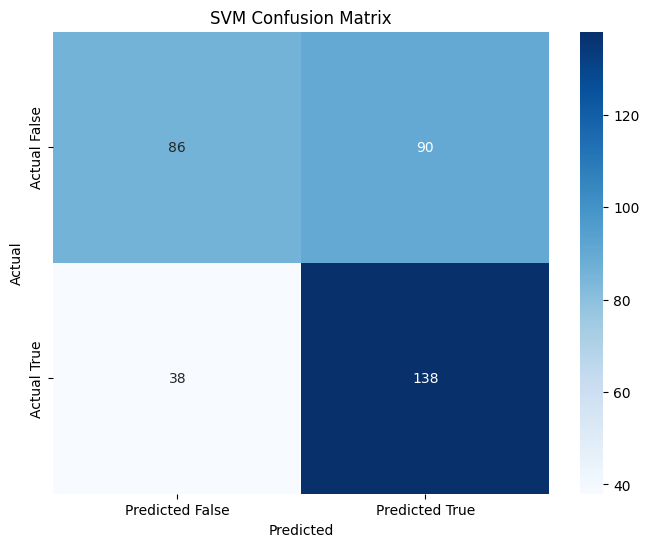

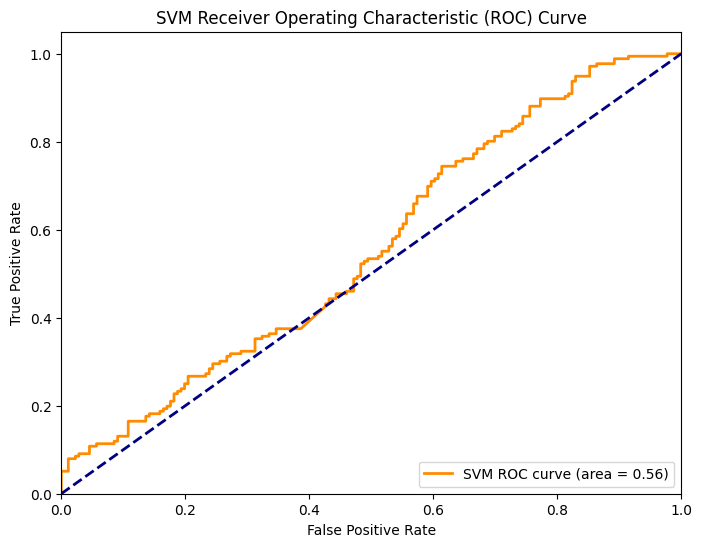

In [ ]:
#for svm
from sklearn.svm import SVC  # Import Support Vector Machine (SVM) classifier

# Initialize lists for storing accuracy and F1-Score
acc_list_svm = []
fm_list_svm = []
all_true_labels_svm = []
all_predicted_labels_svm = []
all_true_probabilities_svm = []

for i in range(1, 89):
    user_number = i
    user_number = str(user_number).zfill(4)
    f = open('behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')
    data = json.load(f)
    user_details = data['details']
    true_data = data['true_data']
    false_data = data['false_data']

    true_k_df_svm = dict_key_conversion(true_data)
    false_k_df_svm = dict_key_conversion(false_data)

    true_m_df_svm = dict_mouse_conversion(true_data)
    false_m_df_svm = dict_mouse_conversion(false_data)

    true_df_svm = feature_gen(true_k_df_svm, true_m_df_svm)
    false_df_svm = feature_gen(false_k_df_svm, false_m_df_svm)
    true_df_svm['label'] = 1
    false_df_svm['label'] = 0
    final_df_svm = pd.concat([true_df_svm, false_df_svm])
    final_df_svm = final_df_svm.reset_index(drop=True)

    y_svm = final_df_svm['label'].tolist()
    X_svm = final_df_svm.drop(['label'], axis=1)
    X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=0)

    # Create and train the SVM classifier
    clf_svm = SVC(probability=True)  # Use SVM classifier with probability output
    clf_svm.fit(X_train_svm, y_train_svm)
    predicted_labels_svm = clf_svm.predict(X_test_svm)
    clf_rep_svm = classification_report(y_test_svm, predicted_labels_svm, output_dict=True)
    acc_svm = clf_rep_svm['accuracy']
    fm_svm = clf_rep_svm['weighted avg']['f1-score']
    print('User', i)
    print('Target Labels', y_test_svm)
    print('Predicted Labels', predicted_labels_svm)
    print('Accuracy:', acc_svm)
    print('F1-Score:', fm_svm)
    print('----------------------------')

    acc_list_svm.append(acc_svm)
    fm_list_svm.append(fm_svm)
    all_true_labels_svm.extend(y_test_svm)
    all_predicted_labels_svm.extend(predicted_labels_svm)

    # Calculate probabilities for ROC curve
    probabilities_svm = clf_svm.predict_proba(X_test_svm)  # Note: Use predict_proba for probability output
    all_true_probabilities_svm.extend(probabilities_svm[:, 1])

final_acc_svm = sum(acc_list_svm) / len(acc_list_svm)
final_fm_svm = sum(fm_list_svm) / len(fm_list_svm)

print(' ')
print('###########################')
print('##########RESULTS##########')
print('###########################')
print('SVM Accuracy:', final_acc_svm)
print('SVM F1-Score:', final_fm_svm)

# Plot the confusion matrix
confusion_matrix_total_svm = confusion_matrix(all_true_labels_svm, all_predicted_labels_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_total_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC for SVM
fpr_svm, tpr_svm, _ = roc_curve(all_true_labels_svm, all_true_probabilities_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
final_df # displays the last df that was passed to the ML algorithms

,dwell_avg,flight_avg,traj_avg,label
0,0.147207,2.751204,574.530501,1
1,0.151566,1.510618,467.405409,1
2,0.160485,0.831984,633.774855,1
3,0.160635,0.872912,590.144207,1
4,0.151265,0.962310,430.895533,1
5,0.146313,0.870686,538.250621,1
6,0.148424,0.791336,578.814630,1
7,0.145037,0.705678,462.138789,1
8,0.154299,0.950675,452.602328,1
9,0.148347,0.723206,460.564528,1
